Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-1-e444cd4a4bc2>:46: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1/14


Training:   0%|          | 0/196 [00:00<?, ?it/s]<ipython-input-1-e444cd4a4bc2>:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision


Train Loss: 0.7209, Test Loss: 0.6494, Accuracy: 93.78%
Epoch 2/14


Train Loss: 0.6180, Test Loss: 0.6623, Accuracy: 93.21%
Epoch 3/14


Train Loss: 0.5844, Test Loss: 0.6067, Accuracy: 95.30%
Epoch 4/14


Train Loss: 0.5629, Test Loss: 0.5969, Accuracy: 95.97%
Epoch 5/14


Train Loss: 0.5464, Test Loss: 0.5920, Accuracy: 96.23%
Epoch 6/14


Train Loss: 0.5301, Test Loss: 0.5791, Accuracy: 96.67%
Epoch 7/14


Train Loss: 0.5179, Test Loss: 0.5828, Accuracy: 96.81%
Epoch 8/14


Train Loss: 0.5094, Test Loss: 0.5633, Accuracy: 97.52%
Epoch 9/14


Train Loss: 0.5040, Test Loss: 0.5591, Accuracy: 97.84%
Epoch 10/14


Train Loss: 0.5021, Test Loss: 0.5538, Accuracy: 98.14%
Epoch 11/14


Train Loss: 0.5017, Test Loss: 0.5538, Accuracy: 98.14%
Epoch 12/14


Train Loss: 0.5014, Test Loss: 0.5545, Accuracy: 98.14%
Epoch 13/14


Train Loss: 0.5018, Test Loss: 0.5552, Accuracy: 98.15%
Epoch 14/14


Train Loss: 0.5020, Test Loss: 0.5661, Accuracy: 97.79%


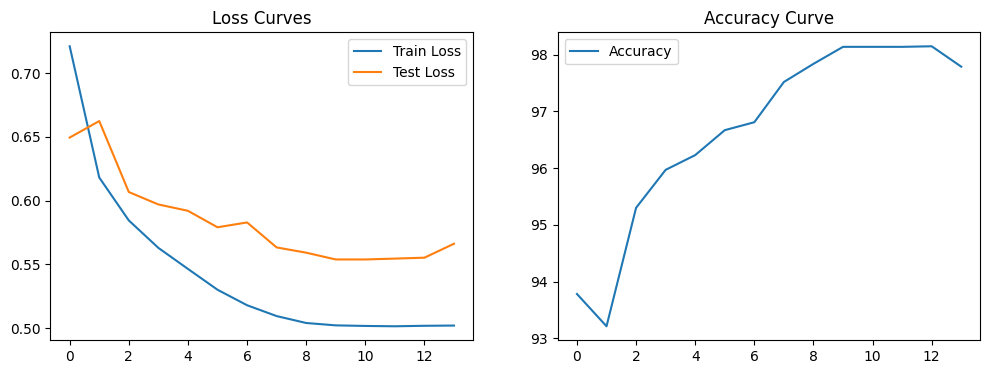

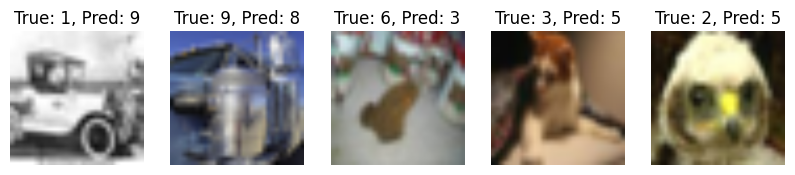

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.models import vit_b_16
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast
from torch.optim.lr_scheduler import CosineAnnealingLR

# 1. Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 2. Data Preparation with Augmentation
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.Resize((224, 224)),  # Resize for ViT input
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for ViT input
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False)

# 3. Model Setup with Pretrained Weights
model = vit_b_16(pretrained=True)
model.heads.head = nn.Linear(model.heads.head.in_features, 10)  # Update classifier for CIFAR-10
model = model.to(device)

# 4. Loss, Optimizer, and Scheduler
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # Label smoothing
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=10)  # Learning rate scheduler

# 5. Mixed Precision Training Setup
scaler = GradScaler()

# 6. Training and Evaluation
num_epochs = 14
train_losses = []
test_losses = []
accuracy = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Training loop
    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast():  # Mixed precision
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Evaluation loop
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_losses.append(test_loss / len(test_loader))
    accuracy.append(100 * correct / total)
    scheduler.step()  # Adjust learning rate

    print(f"Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Accuracy: {accuracy[-1]:.2f}%")

# 7. Visualization
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracy, label='Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

# 8. Save Misclassified Examples
misclassified = []
model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Finding Misclassified", leave=False):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        for i in range(len(labels)):
            if predicted[i] != labels[i]:
                misclassified.append((images[i].cpu(), labels[i].cpu(), predicted[i].cpu()))

# Visualize 5 misclassified images
plt.figure(figsize=(10, 5))
for i in range(min(5, len(misclassified))):
    img, true_label, pred_label = misclassified[i]
    img = img.permute(1, 2, 0) * 0.5 + 0.5  # De-normalize
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f"True: {true_label}, Pred: {pred_label}")
    plt.axis('off')
plt.show()

- False negative
- Accuracy, Recall, Precision, F1
- Set Seed
- Train, Val, Test
- Missclassification Samples
- ROC & AUC
